In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import system libs
import os
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
data_dir = '/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_dir = pd.concat([Fseries, Lseries], axis= 1)
data_dir

,filepaths,labels
0,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
1,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
2,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
3,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
4,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
...,...,...
4357,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc
4358,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc
4359,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc
4360,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc


In [4]:
# train dataframe
train_df, dummy_df = train_test_split(data_dir,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [5]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,        # Randomly rotate images within the range [-30, 30] degrees
    width_shift_range=0.1,    # Shift images horizontally within [-20%, 20%]
    height_shift_range=0.1,   # Shift images vertically within [-20%, 20%]
    zoom_range=0.2,           # Randomly zoom in or out
    fill_mode="nearest",       # Fill in missing pixels using the nearest method
    brightness_range=(0.8, 1.2)
)

ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 3489 validated image filenames belonging to 9 classes.
Found 523 validated image filenames belonging to 9 classes.
Found 350 validated image filenames belonging to 9 classes.


In [6]:
test_gen.class_indices

{'21060451_NguyenHungAnh': 0,
 '21073141_LePhuHao': 1,
 '21075071_NguyenHanhBaoAn': 2,
 '21090261_DuongNgocAnh': 3,
 '21094341_ChauTieuLong': 4,
 '21096911_NguyenNhatTung': 5,
 '21105351_TongThanhLoc': 6,
 '21115461_TuanAnhTran': 7,
 '21119631_NguyenMinhLong': 8}

In [7]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_gen.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: np.float64(0.9965724078834619), 1: np.float64(0.974036850921273), 2: np.float64(0.9572016460905349), 3: np.float64(0.9643449419568823), 4: np.float64(0.9643449419568823), 5: np.float64(0.9991408934707904), 6: np.float64(1.2346072186836519), 7: np.float64(0.9409385113268608), 8: np.float64(1.0228671943711523)}


In [14]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224,224,3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

# Freezing all layers except last 50
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      GlobalAveragePooling2D(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(len(test_gen.class_indices),activation='softmax')
                    ])
    return model

model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,704,969 (90.43 MB)

 Trainable params: 16,488,201 (62.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [15]:
os.makedirs('/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models', exist_ok=True)
cnn_path='/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models'
name = 'ResNet50V2_model_9label.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/ResNet50V2_model_9label.keras'

In [16]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
# Callback for early stopping
earlystop = EarlyStopping(monitor='accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

callbacks = [checkpoint, earlystop]

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8556 - loss: 0.4933
Epoch 1: val_loss improved from inf to 0.01316, saving model to /content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/ResNet50V2_model_9label.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1407s 6s/step - accuracy: 0.8560 - loss: 0.4920 - val_accuracy: 0.9981 - val_loss: 0.0132
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9924 - loss: 0.0434
Epoch 2: val_loss improved from 0.01316 to 0.00583, saving model to /content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/ResNet50V2_model_9label.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 65s 297ms/step - accuracy: 0.9924 - loss: 0.0434 - val_accuracy: 0.9981 - val_loss: 0.0058
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9768 - loss: 0.0750
Epoch 3: val_loss did not improve from 0.00583
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.9769 - loss: 0.0749 - val_accuracy: 0.9

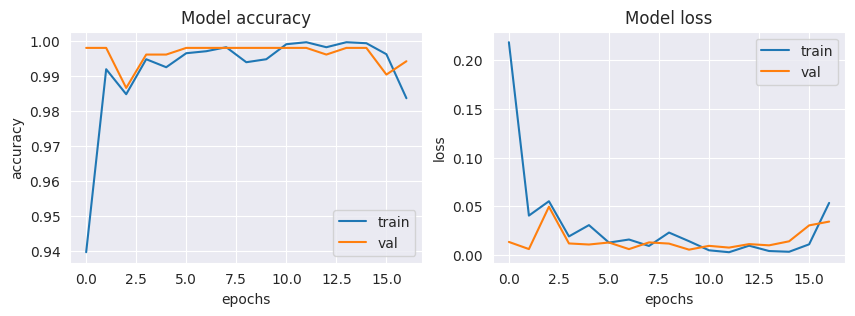

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

22/22 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step


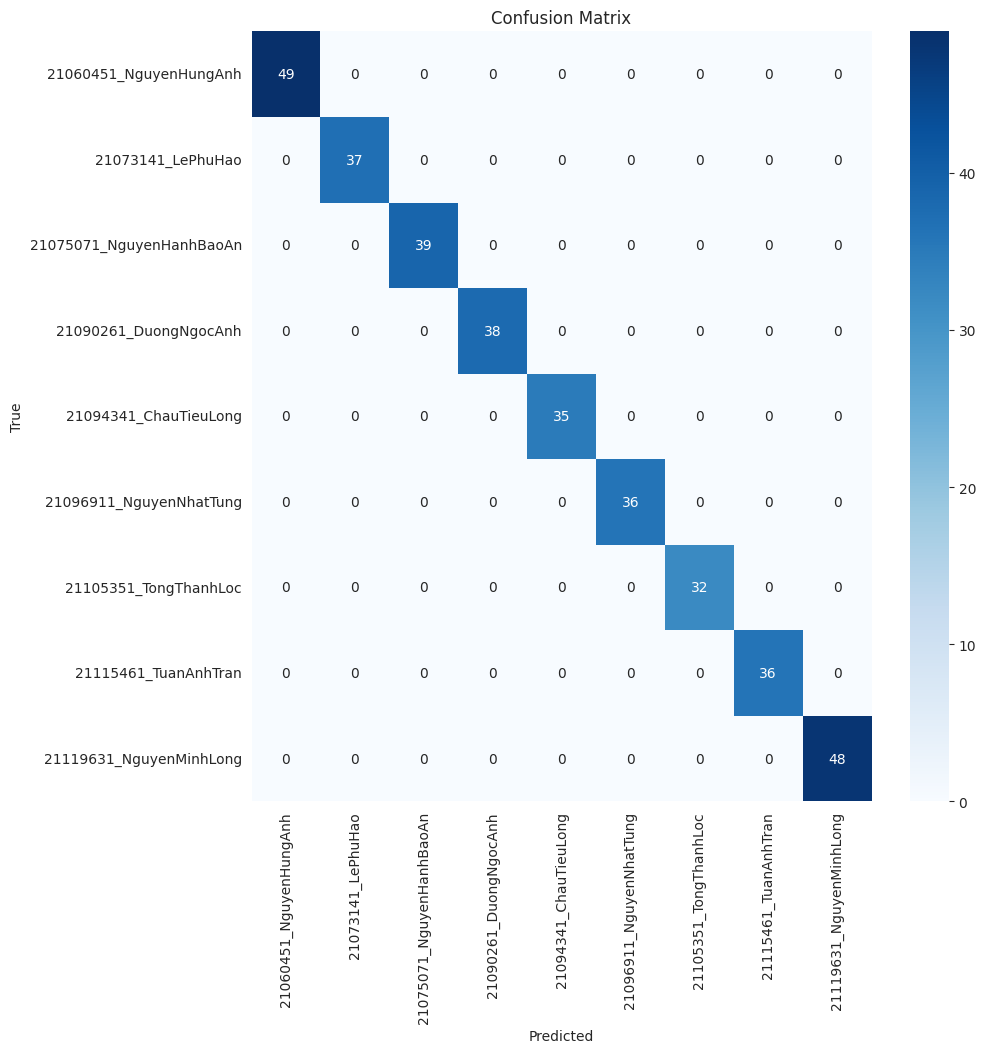

In [19]:
import seaborn as sns
# Generate predictions for the test set
predictions = model.predict(test_gen)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class indices
true_classes = test_gen.classes

# Ensure that the number of true classes and predicted classes are the same
assert len(true_classes) == len(predicted_classes), "Mismatch in the number of samples between true and predicted classes"

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_labels = list(test_gen.class_indices.keys())

# Generate and print the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                           precision    recall  f1-score   support

  21060451_NguyenHungAnh       1.00      1.00      1.00        49
       21073141_LePhuHao       1.00      1.00      1.00        37
21075071_NguyenHanhBaoAn       1.00      1.00      1.00        39
   21090261_DuongNgocAnh       1.00      1.00      1.00        38
   21094341_ChauTieuLong       1.00      1.00      1.00        35
 21096911_NguyenNhatTung       1.00      1.00      1.00        36
   21105351_TongThanhLoc       1.00      1.00      1.00        32
    21115461_TuanAnhTran       1.00      1.00      1.00        36
 21119631_NguyenMinhLong       1.00      1.00      1.00        48

                accuracy                           1.00       350
               macro avg       1.00      1.00      1.00       350
            weighted avg       1.00      1.00      1.00       350



In [21]:
loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc*100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.5143e-06
Test accuracy: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 21094341_ChauTieuLong with confidence score: 100.00%


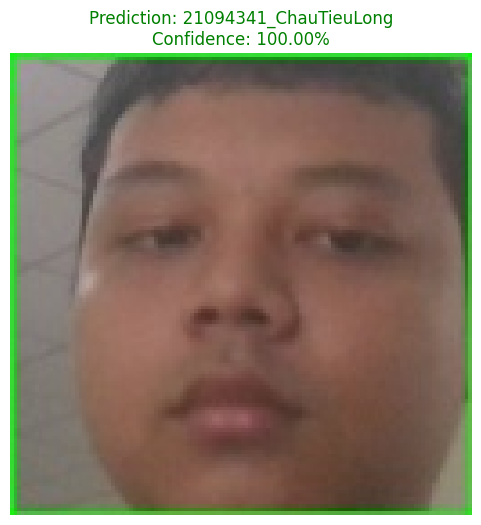

In [22]:

# Lấy tên các lớp (class labels) từ ImageDataGenerator test_gen
class_labels = list(test_gen.class_indices.keys())

# Hàm tiền xử lý ảnh
def preprocess_image(image_path, target_size):
    """
    Mở ảnh, resize, chuyển sang mảng numpy, thêm batch dimension,
    và chuẩn hóa bằng preprocess_input của ResNet50V2.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # [1, 224, 224, 3]
    img_array = preprocess_input(img_array)
    return img_array

# Chọn một ảnh từ lớp 'ChauTieuLong' để kiểm tra
image_path = test_df[test_df["labels"] == "21094341_ChauTieuLong"].iloc[0]["filepaths"]

# Tiền xử lý ảnh đầu vào
input_shape = (224, 224)
preprocessed_image = preprocess_image(image_path, target_size=input_shape)

# Load mô hình đã huấn luyện
model = load_model('/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/ResNet50V2_model_9label.keras')

# Dự đoán nhãn ảnh
predictions = model.predict(preprocessed_image)

# Xác định nhãn được dự đoán và độ tin cậy
predicted_class = class_labels[np.argmax(predictions)]
confidence_score = np.max(predictions)

# In kết quả dự đoán
print(f"Predicted class: {predicted_class} with confidence score: {confidence_score * 100:.2f}%")

# Hiển thị ảnh kèm nhãn dự đoán
plt.figure(figsize=(6, 6))
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score * 100:.2f}%", fontsize=12, color='green')
plt.show()